# Do Book Adaptations Perform Well as Movies?

Making feature films is a high-risk venture. Studios invest millions of dollars creating the next blockbuster with no way of knowing up-front whether their huge investments will turn a profit. When deciding whether to fund a particular movie, what are some pieces of information that would help ensure that the film would be successful? It would help to know that you are investing in a good story, with memorable characters. Something that will connect with the audience. Our project explores the relationship between books and movies to answer the question: do book adaptations perform as well as movies? What does the data tell us about how book adaptations perform after being released as movies, and are they reliably better than the average movie?

In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import ast
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

###  Cleanup and EDA

In [2]:
# Reference csv file paths
goodreads_path = "Raw_Data/books.csv"
keywords_path = "Raw_Data/keywords.csv"
movies_path = "Raw_Data/movies_metadata.csv"
ratings_path = "Raw_Data/ratings.csv"
link_path = "Raw_Data/links.csv"

# Import csv files as DataFrames
# Book data
goodreads_df = pd.read_csv(goodreads_path, encoding="utf-8")
# Movie data
keywords_df = pd.read_csv(keywords_path, encoding="utf-8")
movies_df = pd.read_csv(movies_path, encoding="utf-8")
ratings_df = pd.read_csv(ratings_path, encoding="utf-8")
# Id linking data
link_df = pd.read_csv(link_path, encoding="utf-8")

In [3]:
# Filter df nested dict for 'based on novel' to find book-to-movie adaptations
adaptations = keywords_df[['based on novel' in row for row in keywords_df['keywords']]]

# Convert int to str to merge dfs
adaptations['id'] = adaptations['id'].astype('str')

In [4]:
# Join dfs on 'id' field 
adaptations_merge = pd.merge(adaptations, movies_df,  how = 'inner', on = 'id')

In [5]:
# Select subset of necessary columns for analysis
adaptations_merge = adaptations_merge[['id', 'keywords', 'adult', 'budget', 'genres', 'imdb_id',
                                       'original_language', 'original_title', 'release_date', 
                                      'revenue', 'runtime', 'spoken_languages', 'status', 
                                       'vote_average', 'title']]

# Select movies that have already been released for analysis 
adaptations_merge = adaptations_merge[adaptations_merge['status'] == 'Released']

# Drop rows with NaN values
adaptations_merge = adaptations_merge.dropna(how = 'any')

# Count adaptations
adaptations_merge.count()

id                   829
keywords             829
adult                829
budget               829
genres               829
imdb_id              829
original_language    829
original_title       829
release_date         829
revenue              829
runtime              829
spoken_languages     829
status               829
vote_average         829
title                829
dtype: int64

There are 829 released films based on novels. 

In [6]:
# Drop null rows and convert float to int to remove decimal, then int to str to merge dfs on same datatype
link_df = link_df.dropna()
link_df['tmdbId'] = link_df['tmdbId'].astype(np.int64)
link_df['tmdbId'] = link_df['tmdbId'].astype(np.str)

# Rename tmdbId to id for merging
link_df = link_df.rename(columns = {'movieId': "movieId", 'tmdbId': 'id'})

# Merge movie and ratings data on id field
movies_merge = pd.merge(adaptations_merge, link_df,  how = 'inner', on ='id')

In [7]:
# Select subset of necessary columns for analysis
ratings_df = ratings_df[['movieId', 'rating']]
# Count number of total ratings
ratings_df.count()

movieId    26024289
rating     26024289
dtype: int64

There are ~26M ratings provided for 45,115 unique movies.

In [8]:
# Groupby id to calculate mean of user ratings
ratings_group = ratings_df.groupby('movieId')
ratings_mean = ratings_group['rating'].mean().round(2).reset_index()

In [9]:
# Merge ratings and movie adaptations df
final_movies_df = pd.merge(movies_merge, ratings_mean, how = 'left', on = 'movieId')

In [10]:
# Select subset of necessary columns for analysis
goodreads_df = goodreads_df[['title', 'authors', 'average_rating','  num_pages', 'ratings_count', 'publisher']]

In [11]:
# Merge Goodreads data with final_movies_df
final_df = pd.merge(final_movies_df, goodreads_df, how = 'inner', on = 'title')

In [12]:
# Group by title to sum book ratings
book_ratings = final_df[['title', 'ratings_count']]
groupby_book = book_ratings.groupby('title')
book_ratings_df = groupby_book.sum()
book_ratings_df.shape

(105, 1)

In [13]:
# Drop duplicates from final_df
final_df = final_df.drop_duplicates(subset = ['title'], keep = 'first')
final_df.head(1)
# Verify movie & book count
final_df.shape

(105, 23)

There are 105 matching books and movie adaptations. 

In [14]:
# Create new column for sum of ratings_count 
final_df['sum_of_ratings'] = book_ratings_df['ratings_count'].values
final_df.reset_index(inplace = True, drop=True)

In [15]:
# Convert budget column to numeric and replace 0's with NaN to find missing values
final_df['budget'] = pd.to_numeric(final_df['budget'], errors='coerce')
final_df['budget'] = final_df['budget'].replace(0, np.nan)
final_df[final_df['budget'].isnull()].shape

(49, 24)

In [16]:
# Replace 0's with NaN to detect missing values in revenue column
final_df['revenue'] = final_df['revenue'].replace(0, np.nan)
final_df[final_df['revenue'].isnull()].shape

(47, 24)

In [17]:
# Create new column for the ratio of revenue to budget and detect missing values 
final_df['return'] = final_df['revenue'] / final_df['budget']
final_df[final_df['return'].isnull()].shape

(55, 25)

In [18]:
# Drop unneeded columns from final_df
final_df = final_df.drop(['adult','imdb_id','imdbId', 'status', 'movieId', 
                          'original_title'], axis=1)

In [19]:
# Sort values to find earliest movie release date
final_df.sort_values('release_date').head(2)

,id,keywords,budget,genres,original_language,release_date,revenue,runtime,spoken_languages,vote_average,title,rating,authors,average_rating,num_pages,ratings_count,publisher,sum_of_ratings,return
76,2929,"[{'id': 279, 'name': 'usa'}, {'id': 818, 'name...",NaN,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",en,1910-03-18,NaN,13.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",6.4,Frankenstein,3.18,Mary Wollstonecraft Shelley/J. Paul Hunter,3.79,336,2188,W. W. Norton & Company,111068,NaN
20,138,"[{'id': 272, 'name': 'transylvania'}, {'id': 8...",355000.0,"[{'id': 27, 'name': 'Horror'}]",en,1931-02-12,1012189.0,72.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",7.2,Dracula,3.69,Bram Stoker/Jan Needle/Gary Blythe,3.99,336,73,Walker Books Ltd,197993,2.851237


The earliest movie released was in 1910.

In [20]:
# Rename columns to clean df
final_df = final_df.rename(columns = {'keywords': 'movie keywords', 'budget': 'movie budget', 
                                      'genres': 'movie genre', 'original_language': 'movie original language', 
                                      'release_date': 'movie release date', 'revenue': 'movie revenue',
                                      'runtime': 'movie runtime', 
                                      'spoken_languages': 'movie spoken languages',
                                      'title': 'movie title', 'rating': 'movie rating', 
                                      'authors': 'book authors', 'average_rating' : 'book rating', 
                                      '  num_pages': 'book pages', 'ratings_count': 'book ratings count', 
                                      'publisher' : 'book publisher', 'sum_of_ratings': 'book ratings sum', 
                                      'return': 'movie return'})

In [21]:
# Export full dataset for analysis
final_df.to_csv('book_to_film_adaptations.csv')

In [22]:
# Drop NaN values to find book-to-film adaptations with revenue and budget data
movie_return_df = final_df.dropna(axis=0, subset=['movie return'])
movie_return_df.shape

(50, 19)

There are 50 movies with revenue and budget data

In [23]:
# Export csv of revenue and budget data for analysis
movie_return_df.to_csv('movie_return.csv')

# Hypothesis 1: Book to Film Adaptations have ratings that are statistically different from most films.¶
Hypotheses:

- H0: x(adaptations) = x(population)
- H1: x(adaptations) != x(population)

In [24]:
# Create subsets of data for plotting, and rename columns
imdb_votes_reviews = final_df[['movie title', 'vote_average']]
imdb_votes_reviews = imdb_votes_reviews.rename(columns = {'vote_average': 'Adaptation Films'})

imdb_votes_movies = movies_df[['title', 'vote_average']]
imdb_votes_movies = imdb_votes_movies.rename(columns = {'title': "movie title", 
                                                        'vote_average': 'All Films'})

In [25]:
# Merge dfs on 'movie title'
votes_merge = pd.merge(imdb_votes_movies, imdb_votes_reviews,  how = 'left', on = 'movie title')
votes_merge = votes_merge[['Adaptation Films', 'All Films']]

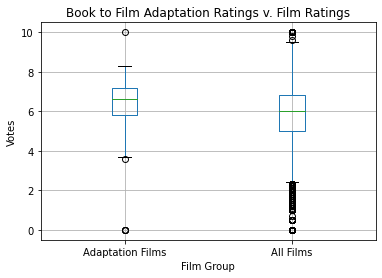

In [26]:
# Generate a box plot of adaptation votes v. total votes, based on IMBD votes
plt.title('Book to Film Adaptation Ratings v. Film Ratings')
plt.ylabel('Votes')
plt.xlabel('Film Group')
votes_merge.boxplot(column=["Adaptation Films", "All Films"])
# Save the figure
plt.savefig("ratings_box_plot.png")
# Visualize
plt.show()

Ratings for Adaptation Films (~7) have a slightly higher mean than All Films (~6). Looking at the box and whisker plot, ratings for All Films vary more widely, with more outliers, than ratings for Adaptation Films. The range of ratings for Adaptation Films is much smaller, with a tighter min and max. The median for All Films is nearly the same rating as Q1 for Adaptation Films. This shows that Adaptation Films are more likely to be rated successfully.

In [27]:
# Function to plot data and define sample v. population
def moviedata(loc=0):
    sample = votes_merge['Adaptation Films']
    population = votes_merge['All Films']

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population)), population, label="population")
    plt.scatter(range(len(sample)), sample, label="sample")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(population, 20, density=True, alpha=0.7, label="population")
    plt.hist(sample, 20, density=True, alpha=0.7, label="sample")
    plt.axvline(population.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(sample.mean(), color='k', linestyle='dashed', linewidth=1)
    # Save the figure
    plt.savefig("hyp_1_subplot.png")
    plt.legend()  
    
    return population, sample

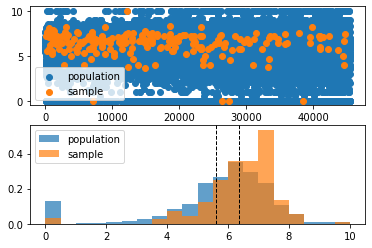

In [28]:
# Plot moviedata in scatter and histogram
population, sample = moviedata()

Looking at the scatter plot, the sample is a good representation of the population, although the sample ratings are primarily between 5 & 10, whereas the population ratings have a much wider variance. Looking at the histogram, data is normally distributed except for a number of films that received a zero rating. The greatest frequency for sample is ~7, whereas the greatest frequency for population is closer to 6.

Assumptions for p-value:
- Data is normally distributed
- Data is independent
- Data is randomly sampled

In [29]:
# Drop NaN values from sample for t-test
sample.dropna(inplace = True)

In [30]:
# Run one sample t-test where significance value is .05
stats.ttest_1samp(sample, population.mean())

Ttest_1sampResult(statistic=8.333635521004798, pvalue=8.03194619929397e-15)

The p-value is small, less than .05. This shows that our null hypothesis is rejected, and proves that the mean rating of Adaptation Films are not equal to All Films. Their means are different. These tests prove our hypothesis that Book to Film Adaptations have ratings that are statistically different than most films.

# Hypothesis 1.1:  Book ratings are positively correlated to Film ratings.

- H1: r2 != 0 (correlation)
- H0: r2 = 0 (no correlation)

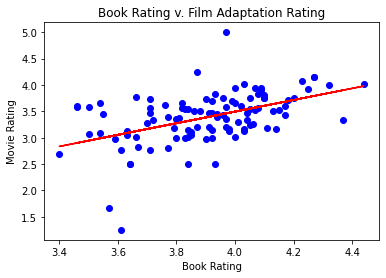

The r-value is: 0.4813170546977568


In [31]:
# Cast book rating as a float
final_df['book rating'] = final_df['book rating'].astype('float')

# Determine x & y values
x_values = final_df['book rating']
y_values = final_df['movie rating']

 # Linear regression model
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
# Plot scatter
plt.scatter(x_values, y_values, color="blue")
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Book Rating')
plt.ylabel('Movie Rating')
marker_size=20
plt.title('Book Rating v. Film Adaptation Rating') 

# Save the figure
plt.savefig("hyp_1.1_regression.png")

# Visualize
plt.show()

# Print r value
print(f"The r-value is: {rvalue}")

Looking at the graph, there is a positive correlation between book and movie rating. 48% of the variability in movie ratings of adaptations is explained by the book rating, assuming that all assumptions of OLS is true. We can infer that book ratings are one factor influencing movie ratings, but there are other factors to consider if we wanted to accurately predict how film adaptations would be received such as budget, movie producer, release date, etc. In order to explore the relationship further, we would need to assess whether the assumptions of the linear regression are valid for this dataset. 

# Hypothesis 2: Horror Adaptation ratings are statistically different from ratings of other film genres.

Hypotheses:
- H0: x(horror adaptations) = x(population)
- H1: x(horror adaptations) != x(population)

In [32]:
# Get values from nested dict
#ast.literal_eval(final_df.iloc[0,4])[0]['name'] 

In [33]:
# lambda x (input) : (output)
#final_df['movie genre'] = final_df['movie genre'].apply(lambda x:ast.literal_eval(x)[0]['name'])

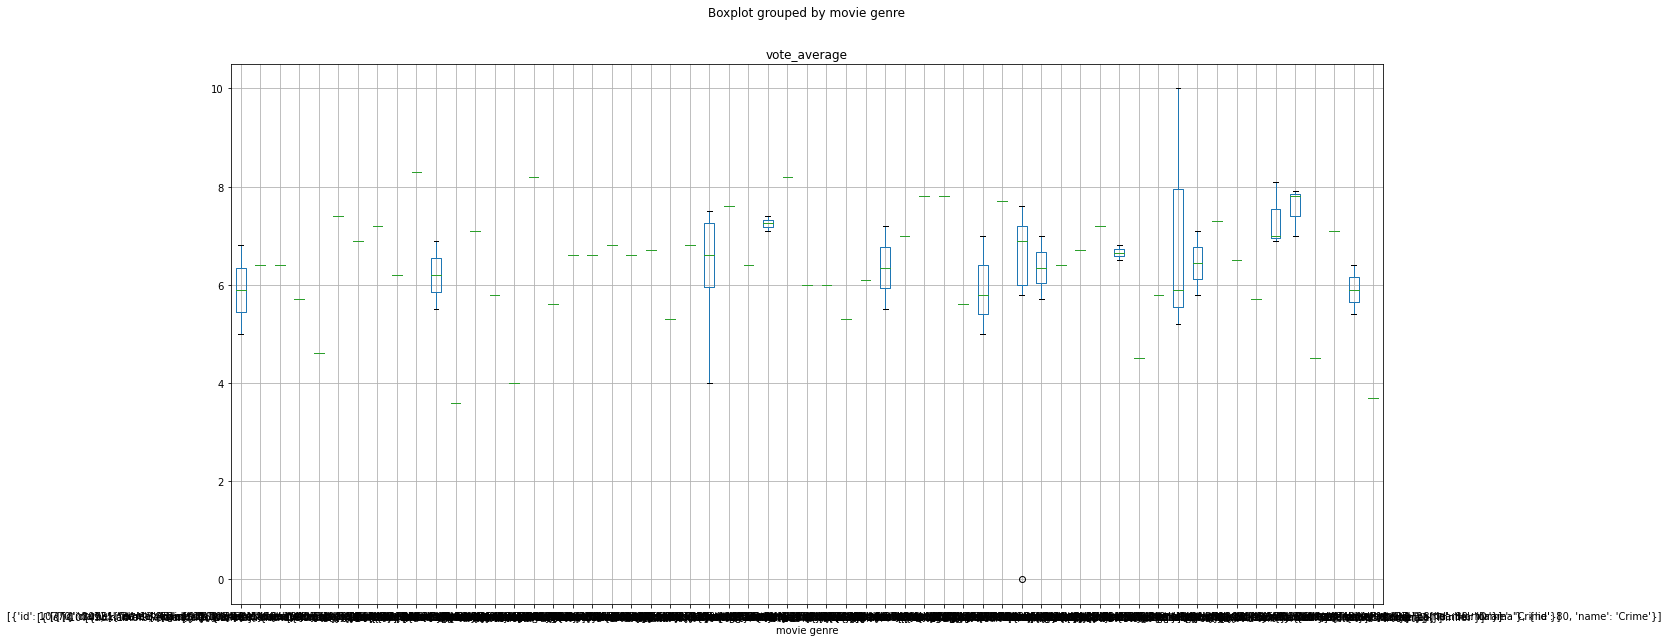

In [34]:
# Create a boxplot to compare means of top 6 rated genres
final_df.boxplot("vote_average", by="movie genre", figsize=(20, 10))

# Save the figure
plt.savefig("hyp_2.png")

# Visualize
plt.show();

Ratings for Crime Adaptation Films have a slightly higher mean than other genres. Looking at the box and whisker plot, ratings for Mystery Films vary more widely than other genres. This plot shows that Crime, Drama and Adventure book to film adaptations are more likely to be rated slightly more successfully than other genres. Horror films and Family films tend to be well rated as well, with a low variance of user ratings.

In [35]:
# Extract individual groups for top genres by rating
group1 = final_df[final_df["movie genre"] == 'Drama']["vote_average"]
group2 = final_df[final_df["movie genre"] == 'Crime']["vote_average"]
group3 = final_df[final_df["movie genre"] == 'Mystery']["vote_average"]
group4 = final_df[final_df["movie genre"] == 'Adventure']["vote_average"]
group5 = final_df[final_df["movie genre"] == 'Horror']["vote_average"]

In [36]:
# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4, group5)

F_onewayResult(statistic=nan, pvalue=nan)

Results: The p-value is greater than .05. Therefore, we failed to reject the null hypothesis. We can infer that book to film adaptations in the horror genre are not a standout. Genres like Crime, Mystery, Adventure and Drama have similarly positive reviews. Their means are similar showing that book to film adaptations tend to do well at the box office, regardless of genre.

# Hypothesis 3: Is there a relationship / correlation between the number of reviewers of a book, and the movie rating?
- H1: r2 != 0 (correlation)
- H0: r2 = 0 (no correlation)

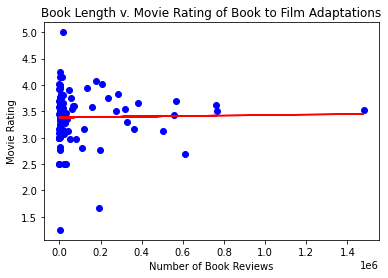

The r-value is: 0.019169007359004328


In [37]:
# Determine x & y values
x_values = final_df['book ratings count']
y_values = final_df['movie rating']

 # Linear regression model
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
# Plot scatter
plt.scatter(x_values, y_values, color="blue")
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Number of Book Reviews')
plt.ylabel('Movie Rating')
marker_size=20
plt.title('Book Length v. Movie Rating of Book to Film Adaptations')

# Save the figure
plt.savefig("hyp_3.png")

# Visualize
plt.show()

# Print r value
print(f"The r-value is: {rvalue}")

From the pattern observed from the scatterplot and regression, the low rvalue shows that there is not a relationship between the number of pages in a novel and the rating of the film adaptation. The r squared value of 1% can be interpreted as the length of the book explains 1% of the variation in film adaptation scores. Therefore, we can infer that the relationship between these variables is not very meaningful. 

# Hypothesis 4: Is there a relationship / correlation between the number of Goodreads book reviews and the movie rating?
- H1: r2 != 0 (correlation)
- H0: r2 = 0 (no correlation)

In [38]:
# Cast book pages as int
final_df['book pages'] = final_df['book pages'].astype('int64')

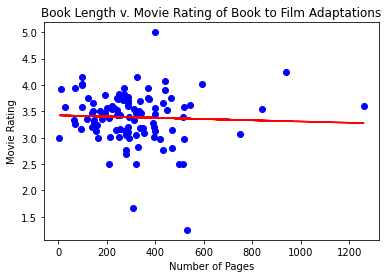

The r-value is: -0.043778432195029734


In [39]:
# Determine x & y values
x_values = final_df['book pages']
y_values = final_df['movie rating']

 # Linear regression model
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
# Plot scatter
plt.scatter(x_values, y_values, color="blue")
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Number of Pages')
plt.ylabel('Movie Rating')
marker_size=20
plt.title('Book Length v. Movie Rating of Book to Film Adaptations')

# Save the figure
plt.savefig("hyp_4.png")

# Visualize
plt.show()

# Print r value
print(f"The r-value is: {rvalue}")

From the pattern observed from the scatterplot and regression, the low rvalue shows that there is not a relationship between the number of goodreads reviews and the rating of the film adaptation. The r squared value of 4% can be interpreted as the book rating explains 4% of the variation in film adaptation scores. Therefore, we can also infer that the relationship between these variables is not very meaningful.